## **Classificação automática de notícias com NLP: Identificação de Fake News**

**Objetivo:**

Utilizar a classificação de notícias com NLP para identificar se uma notícia é real ou falsa, com base apenas em seu conteúdo textual.

**Contexto:**

Como a aplicação de NLP para identificação de notícias falsas pode nos auxiliar no nosso dia a dia, no combate à desinformação. Com a aplicação de técnicas de Processamento de Linguagem Natural (NLP) para classificar automaticamente notícias como verdadeiras ou falsas, utilizando um modelo supervisionado treinado com dados rotulados é possível utilizar o NLP no combate à desinformação digital, automatizando a identificação de fake news com base no conteúdo textual.

**Onde pode ser encontrado?**

*   Dataset: Fake and Real News Dataset
*   Link: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
*   Origem: Kaggle
*   Tamanho: ~44.000 notícias (divididas em classes “real” e “fake”)

**Descrição do Dataset:**
Este conjunto de dados contém manchetes e conteúdos de notícias classificadas como reais (provenientes de fontes confiáveis como Reuters, HuffPost) e falsas (extraídas de sites conhecidos por disseminar desinformação). Cada entrada possui:
*   Título da notícia
*   Texto completo
*   Categoria (fake ou real)


### **Carregamento dos Dados**


In [51]:
!pip install scikit-learn matplotlib seaborn pandas nltk

In [52]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [53]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
from google.colab import drive
drive.mount('/content/drive')

df_fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
df_fake['label'] = 0  # Fake
df_true['label'] = 1   # Real

# Concatenar os dataframes e embaralhar
df = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

In [56]:
print("Dados Carregados e Combinados")
print(f"Total de notícias: {len(df)}")

Dados Carregados e Combinados
Total de notícias: 44898


In [57]:
df.shape

(44898, 5)

In [58]:
# Tipagem dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [59]:
# Primeiros dados

df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [60]:
#Últimos dados

df.tail()

,title,text,subject,date,label
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0
44897,BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...,IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...,politics,"Apr 23, 2015",0


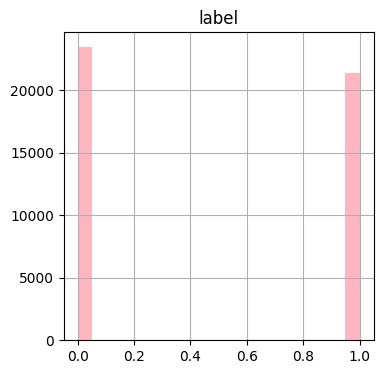

In [61]:
#Análise por variável

eixo = df.hist(bins=20, color='lightpink', figsize=(4,4))

In [62]:
print("Distribuição das classes:")
print(df['label'].value_counts())

Distribuição das classes:
label
0    23481
1    21417
Name: count, dtype: int64


In [63]:
print("Verificando valores nulos:")
print(df.isnull().sum())

Verificando valores nulos:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


### **Pré-processamento de Texto**
Esta etapa limpa e padroniza o texto das notícias. Isso inclui converter para minúsculas, remover URLs e caracteres especiais, e aplicar tokenização, remoção de stop words e lematização. O objetivo é preparar o conteúdo textual para ser processado pelo modelo de forma eficiente.

In [64]:
# Pré-processamento de Texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['processed_text'] = df['full_text'].apply(preprocess_text)

In [65]:
print("Pré-processamento de Texto Concluído")
print("\nExemplo de texto original vs. processado:")
print(f"Original (primeiros 200 caracteres): {df['full_text'].iloc[0][:200]}...")
print(f"Processado (primeiros 200 caracteres): {df['processed_text'].iloc[0][:200]}...")

Pré-processamento de Texto Concluído

Exemplo de texto original vs. processado:
Original (primeiros 200 caracteres): Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame...
Processado (primeiros 200 caracteres): ben stein call th circuit court committed coup dtat constitution st century wire say ben stein reputable professor pepperdine university also hollywood fame appearing tv show film ferris bueller day m...


### **Divisão dos Dados e Vetorização TF-IDF**
Os dados são divididos em conjuntos de treino e teste. O texto pré-processado é então convertido em representações numéricas usando TF-IDF (Term Frequency-Inverse Document Frequency), que atribui pesos às palavras com base em sua importância no documento e no corpus, tornando-as compreensíveis para algoritmos de machine learning.

In [66]:
# Divisão dos Dados
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

Tamanho do conjunto de treino: 35918
Tamanho do conjunto de teste: 8980


In [67]:
# Vetorização TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensões dos dados de treino TF-IDF: {X_train_tfidf.shape}")
print(f"Dimensões dos dados de teste TF-IDF: {X_test_tfidf.shape}")

Dimensões dos dados de treino TF-IDF: (35918, 5000)
Dimensões dos dados de teste TF-IDF: (8980, 5000)


### **Construção e Treinamento do Modelo (com Early Stopping)**
Uma rede neural é construída e treinada para classificar as notícias. O modelo utiliza camadas densas e dropout para aprendizado e regularização. A técnica de EarlyStopping é implementada para prevenir o overfitting, interrompendo o treinamento se a performance em validação não melhorar após algumas épocas, garantindo um modelo mais robusto.

Treinando o Modelo com Early Stopping
Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9399 - loss: 0.1839 - val_accuracy: 0.9916 - val_loss: 0.0227
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.9925 - val_loss: 0.0249
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9984 - loss: 0.0048 - val_accuracy: 0.9928 - val_loss: 0.0230
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.9928 - val_loss: 0.0301
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9916 - val_loss: 0.0282
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9922 - val_loss: 0.0287
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9930 - val_loss: 0.0328
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━

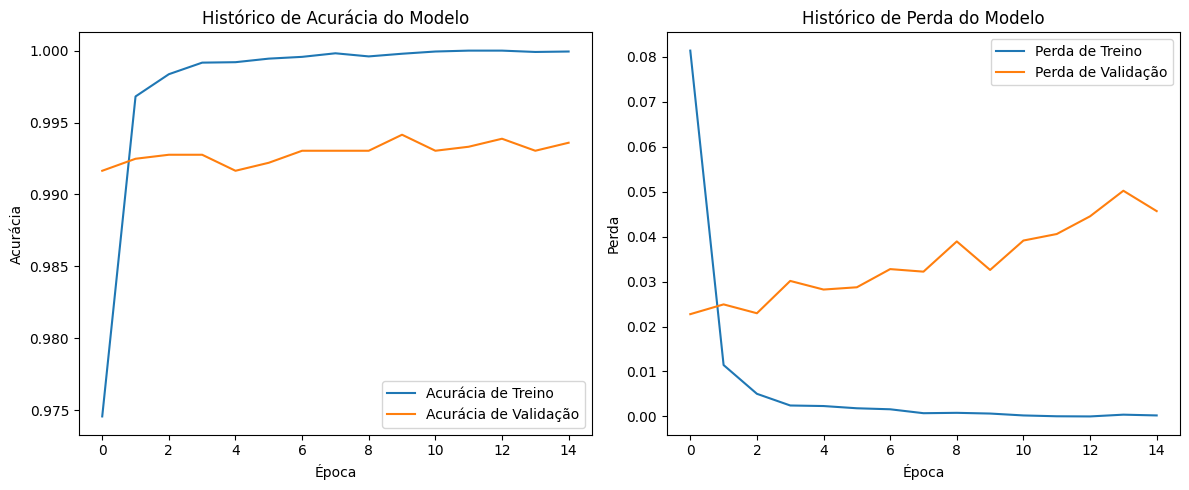

In [68]:
# Construção e Treinamento do Modelo com Early Stopping
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],), sparse=True),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

print("Treinando o Modelo com Early Stopping")
history = model.fit(X_train_tfidf, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)

print("\nTreinamento do modelo concluído!")

# Plotar o histórico para visualizar o overfitting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Histórico de Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Histórico de Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

### **Avaliação do Modelo**
São calculadas métricas chave como acurácia, precisão, recall e F1-score, e uma matriz de confusão é gerada para visualizar a performance da classificação de notícias reais e falsas.

In [69]:
# Avaliação do Modelo
print("Avaliando o Modelo no Conjunto de Teste")
loss, accuracy = model.evaluate(X_test_tfidf, y_test, verbose=0)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
print(f"Perda no conjunto de teste: {loss:.4f}")

y_pred_proba = model.predict(X_test_tfidf)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nMétricas Detalhadas")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

Avaliando o Modelo no Conjunto de Teste
Acurácia no conjunto de teste: 0.9928
Perda no conjunto de teste: 0.0570
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Métricas Detalhadas
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



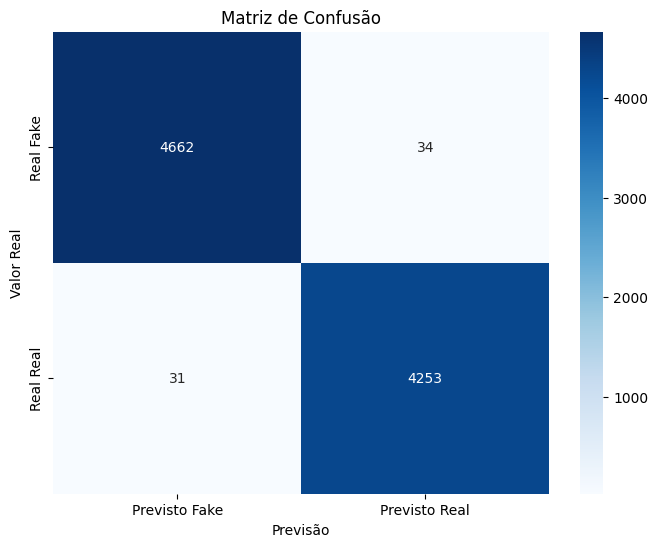

Acurácia: 0.9928
Precisão (Fake): 0.9921
Recall (Fake): 0.9928
F1-Score (Fake): 0.9924


In [70]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Fake', 'Previsto Real'], yticklabels=['Real Fake', 'Real Real'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (Fake): {precision:.4f}")
print(f"Recall (Fake): {recall:.4f}")
print(f"F1-Score (Fake): {f1:.4f}")